# GMM - Anomaly Detection

En éste notebook vamos a explorar las aplicaciones de los Gaussian Mixture Models a la detección de anomalías.

## Cargamos las Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture

In [2]:
GaussianMixture?

Init signature:
GaussianMixture(
    n_components=1,
    *,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weights_init=None,
    means_init=None,
    precisions_init=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10,
)
Docstring:     
Gaussian Mixture.

Representation of a Gaussian mixture model probability distribution.
This class allows to estimate the parameters of a Gaussian mixture
distribution.

Read more in the :ref:`User Guide <gmm>`.

.. versionadded:: 0.18

Parameters
----------
n_components : int, default=1
    The number of mixture components.

covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
    String describing the type of covariance parameters to use.
    Must be one of:

    - 'full': each component has its own general covariance matrix.
    - 'tied': all components share the same general covariance matrix.
    - 'diag': each co

## Datasets Sintéticos

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

Usamos make_blobs de sklearn para generar datasets sintéticos. [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [4]:
# Dataset original
X, y_true = make_blobs(n_samples=1000, centers=5, cluster_std=0.60, random_state=1)

# Outliers
X_append, y_true_append = make_blobs(n_samples=50,centers=5, cluster_std=5,random_state=1)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.30, random_state=1, shuffle=True)

Text(0.5, 1.0, 'Valores normales')

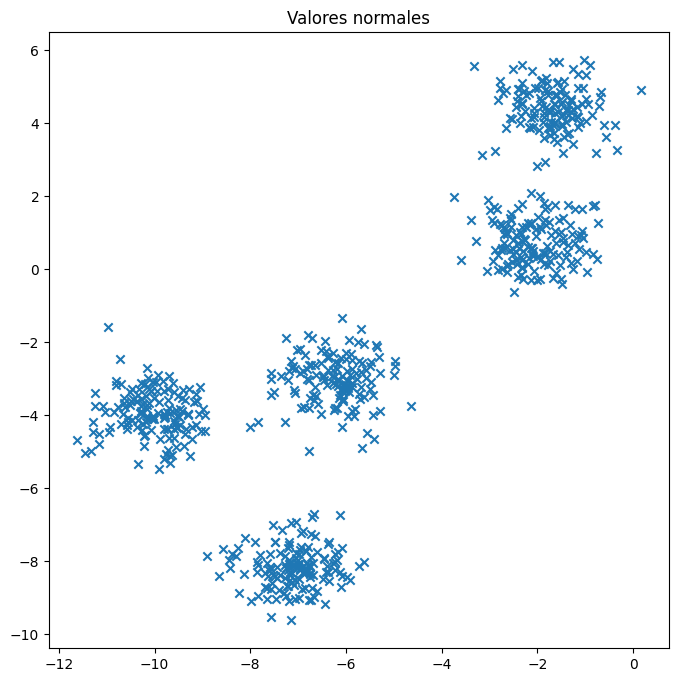

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(X_train[:,0],X_train[:,1],marker="x")
plt.title("Valores normales")

Text(0.5, 1.0, 'Valores Anómalos')

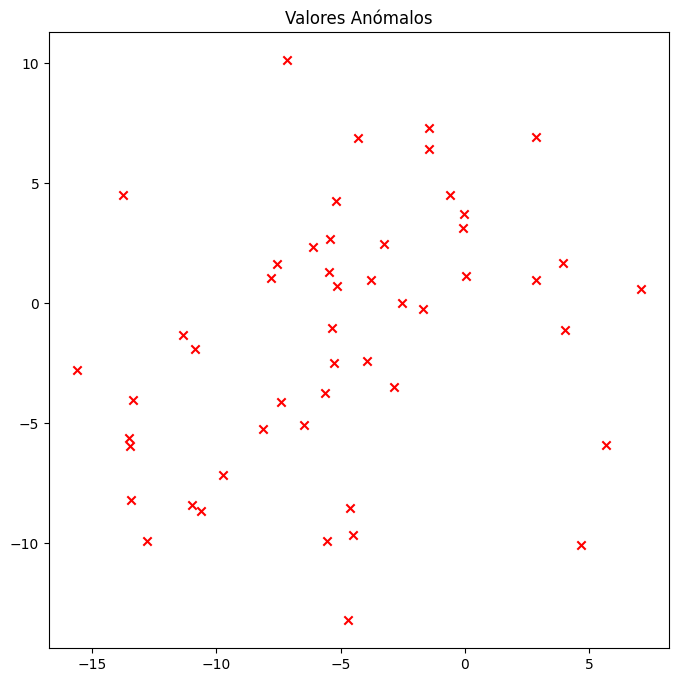

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(X_append[:,0],X_append[:,1],marker="x", c='r')
plt.title("Valores Anómalos")

In [8]:
gm = GaussianMixture(n_components = 5, covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(n_components=5, random_state=0)

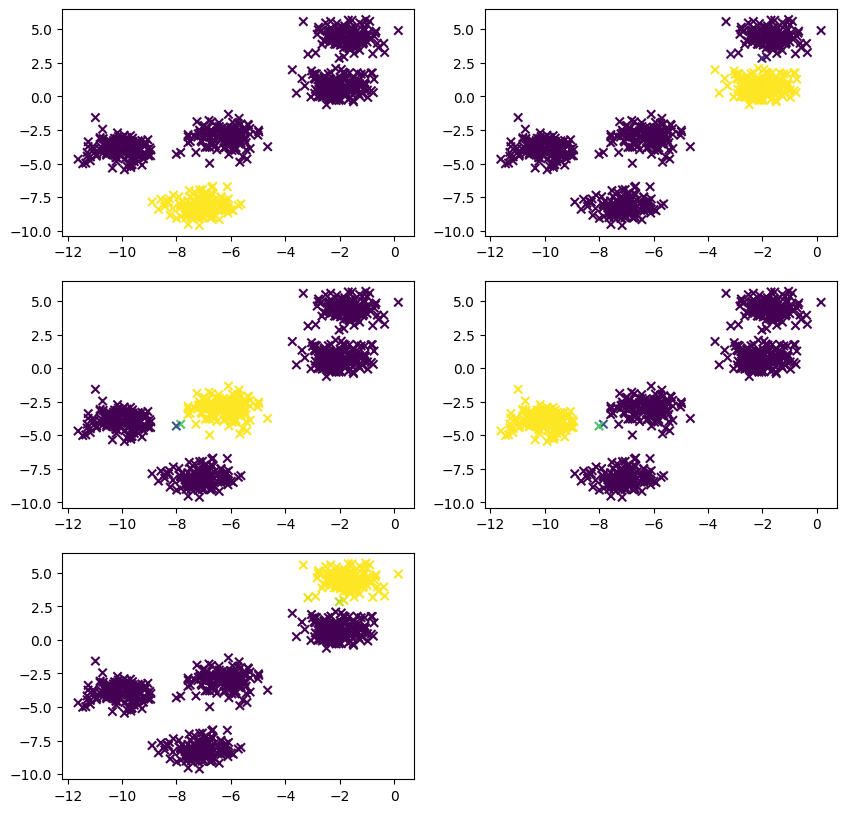

In [9]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(3, 2, i + 1)
    plt.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c=gm.predict_proba(X_train)[:, i],
        cmap="viridis",
        marker="x",
    )

In [10]:
log_prob_train = gm.score_samples(X=X_train)

In [30]:
np.min(log_prob_train)

-10.503673799046625

In [11]:
log_prob = gm.score_samples(X=X_append)

In [12]:
np.min(log_prob)

-201.87236245097637

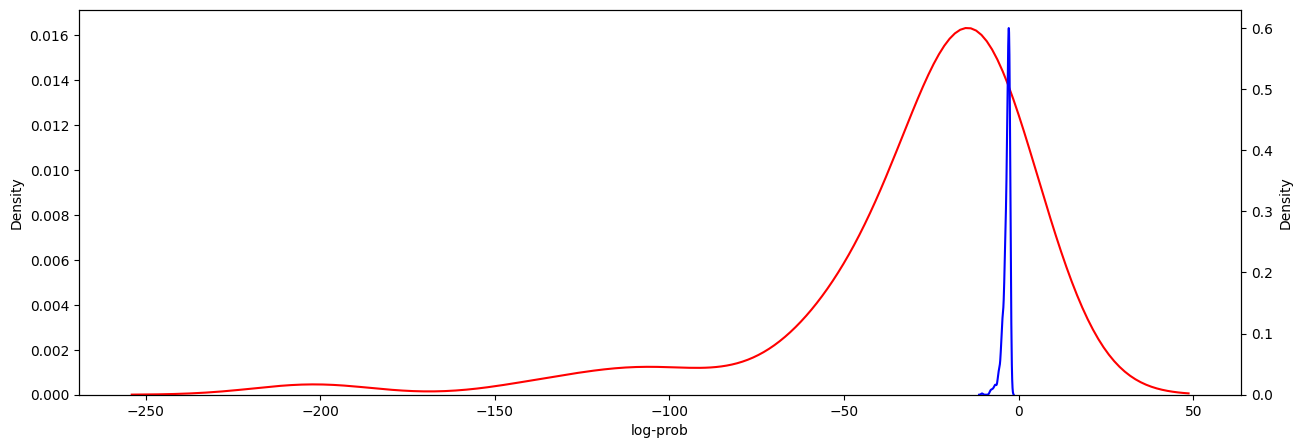

In [13]:
f, ax = plt.subplots(figsize=(15,5))

sns.kdeplot(
    data = log_prob,
    color   = 'red',
    ax      = ax
)
ax2 = ax.twinx()

sns.kdeplot(
    x = log_prob_train,
    color   = 'blue',
    ax      = ax2
)
ax.set_xlabel('log-prob')
plt.show()

In [31]:
np.exp(-10.5)

2.7536449349747158e-05

In [15]:
# Tomamos como umbral log_prob <-6

anomaly_mask = log_prob<-6
y = np.zeros(X_append.shape[0])
y[anomaly_mask]=1

In [16]:
np.sum(y)

44.0

Text(0.5, 1.0, 'Distribución puntos normales')

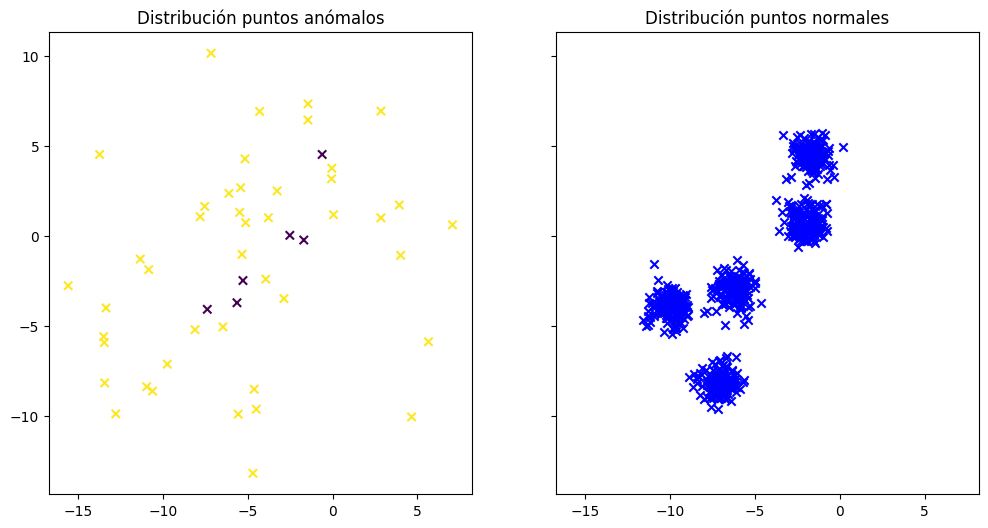

In [17]:
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey='row', sharex='row')

ax_1.scatter(X_append[:,0], X_append[:,1], marker="x", c=y, cmap='viridis')
ax_1.set_title("Distribución puntos anómalos")

ax_2.scatter(X_train[:,0], X_train[:,1], marker="x", c='b')
ax_2.set_title("Distribución puntos normales")

## Dataset Old Faithful

### Cargamos los Datos

Es un dataset que contiene información sobre la duración e intervalos entre erupciones del geiser de Yellowstone.

In [18]:
data = pd.read_csv('data/OldFaithful.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   waiting   299 non-null    int64  
 1   duration  299 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


In [32]:
data.head()

,waiting,duration
0,80,4.016667
1,71,2.150000
2,57,4.000000
3,80,4.000000
4,75,4.000000


In [19]:
data.describe()

,waiting,duration
count,299.000000,299.000000
mean,72.314381,3.460814
std,13.890324,1.147904
min,43.000000,0.833333
25%,59.000000,2.000000
50%,76.000000,4.000000
75%,83.000000,4.383333
max,108.000000,5.450000


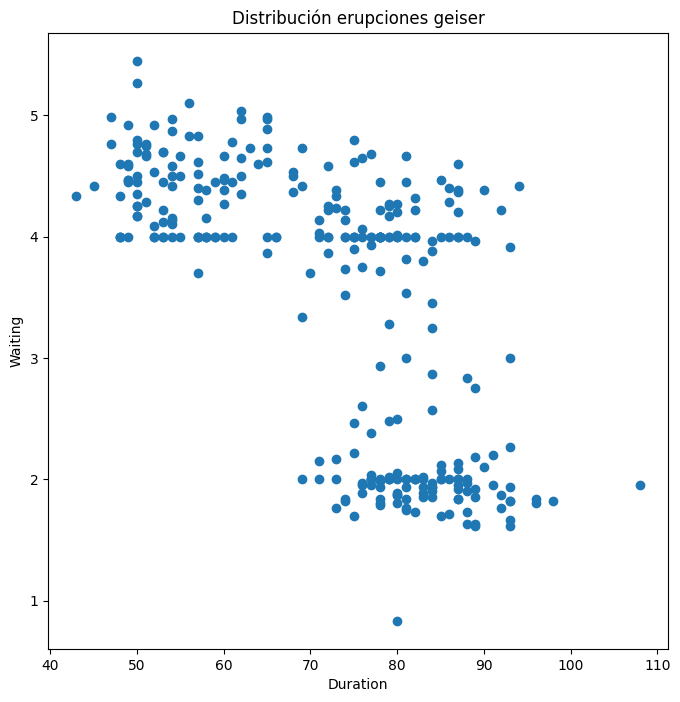

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

ax.scatter(data.waiting, data.duration)
ax.set_title('Distribución erupciones geiser')
ax.set_ylabel('Waiting')
ax.set_xlabel('Duration');

A simpe vista, pareciera que hay tres clusters bien marcados. Podemos entrenar entonces un modelo con GMM e intentar identificar las anomalías a partir del mísmo.

In [21]:
data_np = data.to_numpy()

In [22]:
gm = GaussianMixture(n_components = 3, covariance_type = 'diag', random_state = 123)
gm.fit(X=data_np)

GaussianMixture(covariance_type='diag', n_components=3, random_state=123)

In [23]:
log_prob = gm.score_samples(X=data_np)

Como no conocemos cuáles son las anomalías de nuestro dataset y no tenemos un dataset de valores normales (con alto nivel de confianza) sobre el cual entrenar el modelo, vamos a escoger como anomalías los 20 puntos con menor log de distribución de probabilidad. Lo ideal sería utilizar un umbral como en el ejemplo de más arriba.

In [24]:
df_resultados = pd.DataFrame(data)
df_resultados['log_proba'] = log_prob
df_resultados = df_resultados.sort_values(by='log_proba')

anomalias = df_resultados.head(20)
anomalias

,waiting,duration,log_proba
148,80,0.833333,-16.088619
60,108,1.950000,-9.569015
11,50,5.450000,-8.253496
242,93,3.000000,-7.851804
131,94,4.416667,-7.599905
269,89,2.750000,-7.205645
40,93,2.266667,-7.041359
207,77,2.383333,-7.039012
132,75,2.466667,-7.035490
61,50,5.266667,-6.877098


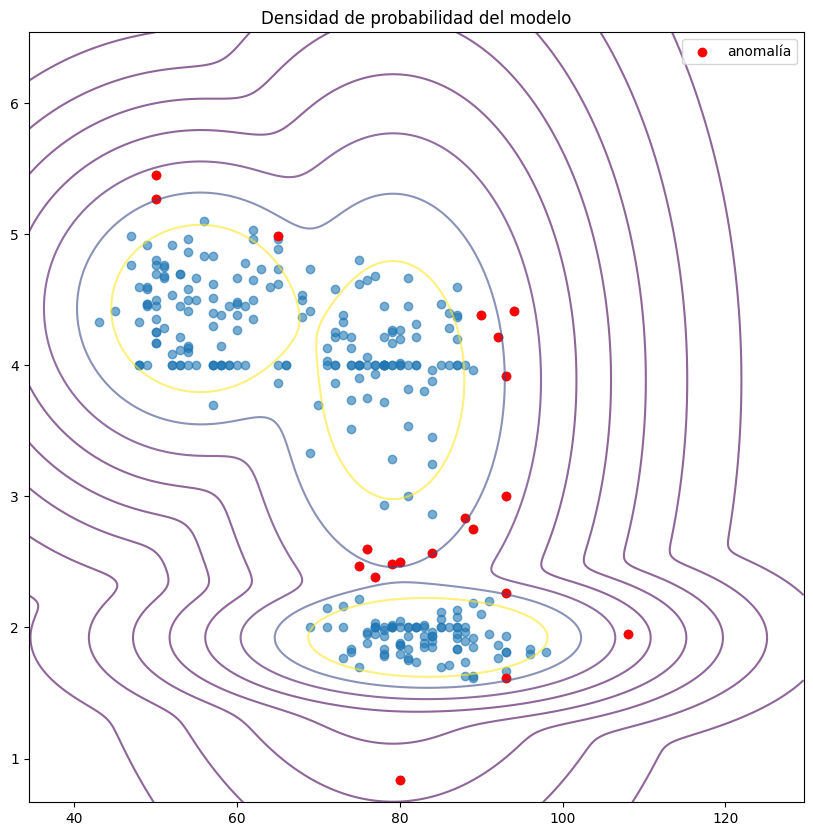

In [25]:
# Graficamos los resultados (sacado de scikit learn y bibliografía)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# Grid de valores dentro del rango observado
x = np.linspace(min(df_resultados.waiting)*0.8, max(df_resultados.waiting)*1.2, 1000)
y = np.linspace(min(df_resultados.duration)*0.8, max(df_resultados.duration)*1.2, 1000)
xx, yy = np.meshgrid(x, y)

# Densidad de probabilidad de cada valor del grid
scores = gm.score_samples(np.c_[xx.ravel(), yy.ravel()])

# Los valores están en log
scores = np.exp(scores) 

ax.scatter(df_resultados.waiting, df_resultados.duration, alpha=0.6)
ax.scatter(anomalias.waiting, anomalias.duration, c="red", label='anomalía')
ax.contour(
    xx, yy, scores.reshape(xx.shape),
    alpha=0.6, cmap='viridis',
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
ax.set_title('Densidad de probabilidad del modelo')
ax.legend();

---

## Dos clusters

In [26]:
gm2 = GaussianMixture(n_components = 2, covariance_type = 'diag', random_state = 123)
gm2.fit(X=data_np)

GaussianMixture(covariance_type='diag', n_components=2, random_state=123)

In [27]:
log_prob2 = gm2.score_samples(X=data_np)

In [28]:
df_resultados2 = pd.DataFrame(data)
df_resultados2['log_proba'] = log_prob2
df_resultados2 = df_resultados2.sort_values(by='log_proba')

anomalias2 = df_resultados2.head(20)
anomalias2

,waiting,duration,log_proba
60,108,1.950000,-12.811043
11,50,5.450000,-8.457616
182,98,1.816667,-7.909494
267,96,1.800000,-7.202778
154,96,1.833333,-7.171432
61,50,5.266667,-7.054187
131,94,4.416667,-7.048193
215,93,1.616667,-6.484496
163,69,2.000000,-6.453808
287,93,1.666667,-6.429880


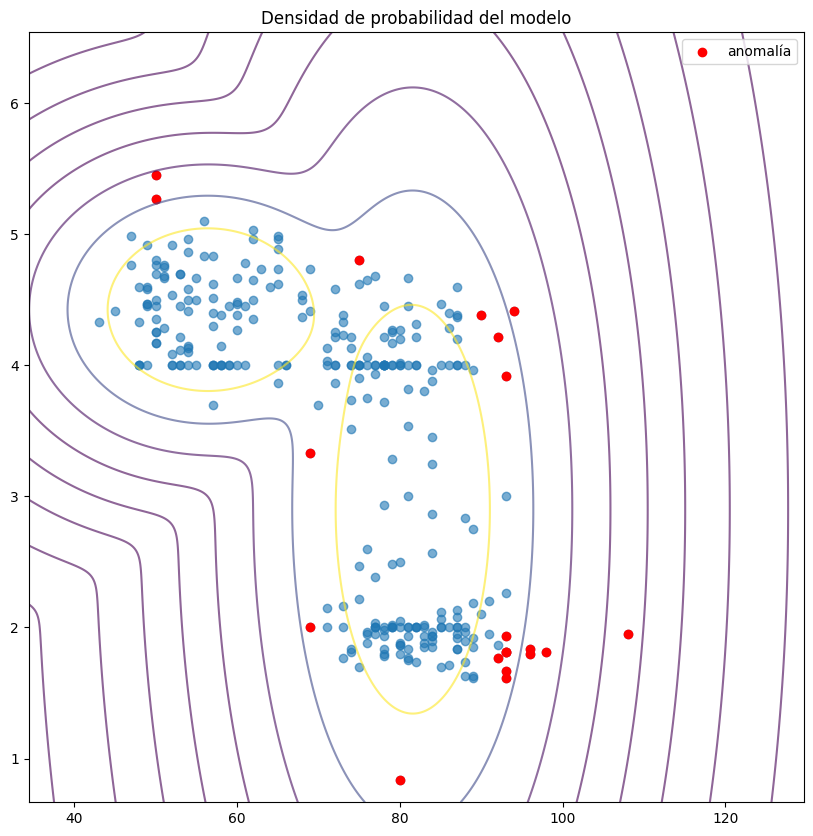

In [29]:
# Graficamos los resultados (sacado de scikit learn y bibliografía)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# Grid de valores dentro del rango observado
x = np.linspace(min(df_resultados2.waiting)*0.8, max(df_resultados2.waiting)*1.2, 1000)
y = np.linspace(min(df_resultados2.duration)*0.8, max(df_resultados2.duration)*1.2, 1000)
xx, yy = np.meshgrid(x, y)

# Densidad de probabilidad de cada valor del grid
scores2 = np.exp( gm2.score_samples(np.c_[xx.ravel(), yy.ravel()]) )


ax.scatter(df_resultados2.waiting, df_resultados2.duration, alpha=0.6)
ax.scatter(anomalias2.waiting, anomalias2.duration, c="red", label='anomalía')
ax.contour(
    xx, yy, scores2.reshape(xx.shape),
    alpha=0.6, cmap='viridis',
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
ax.set_title('Densidad de probabilidad del modelo')
ax.legend();

## Bibliografía

* Anomaly Detection in Python with Gaussian Mixture Models. Agasti Kishor Dukare
* Detección de anomalías con Gaussian Minture Modedel (GMM) y python. Joaquín Amat Rodrigo